

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project  



# Machine Learning Final Project: Tidal bars in Estuaries and Deltas

#### by Fernando Rey
#### Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Introduction 

I want to work with data from tidal bars measurements used by Leuven et al. (2016). In their work they concluded that the tidal bar length and bar width are strongly correlated to estuary width.

I chose this work for two reasons:
 
1.	Because their data was available in their publication and was free to use. 
2.	Because in their work they only perform linear regression related methods with the data, and I wanted to explore a different approach.



### Executive Summary

I chose this dataset because it was open to be used without restriction, and in the original work where it was published (Leuven et al.,2016), they only performed linear regression related methods with the data, and I wanted to explore a different approach. In order to explore the dataset and choose the correct predictor features, I started with a ranking feature approach; then I used inferential (Multidimensional scaling and PCA) and prediction (Naïve Bayes) to explore the data and to understand the relationship between the predictor and response features. I learned that the best way to predict the response features (width and length of the tidal bars) is to use two key predictor features (width and length of the local Estuary/delta). The following steps will use these two predictor features (width and length of the local Estuary/delta) in other prediction-based models (random forest, boosting and support vector machines) to try to improve Leuven et al. (2016) interpretation; additionally I would like to increase my dataset with new measurements because I think that 190 datapoints are probably not enough to have a representative sample. 


### Import Packages

In [9]:
#General Use
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
import copy 
import pandas.plotting as pd_plot

#Ranking Features
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression
from scipy import linalg                  # for linear regression

#Inferential Models: MDS
from sklearn.manifold import MDS          # multidimensional scaling
from sklearn.random_projection import GaussianRandomProjection # random projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler            # standardize the features.  It will be use also in Polynomial regression

#Inferential Models: PCA
from sklearn.decomposition import PCA

#Predictor base models:
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.naive_bayes import GaussianNB                  # naive Bayes model and prediction
from sklearn import metrics                                 # measures to check our models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Functions

The following functions will be used in the workflow.
The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Feature_ranking.ipynb from GeostatsGuy GitHub (https://github.com/GeostatsGuy/SubsurfaceMachineLearning/tree/master/Demos)


In [2]:
def partial_corr(C):                                      #partial correlation function, I will use it for ranking features
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

The following functions will be used in the workflow. The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Naïve_Bayes.ipynb from GeostatsGuy GitHub (https://github.com/GeostatsGuy/SubsurfaceMachineLearning/tree/master/Demos).

In [126]:
def plot_corr(dataframe,size=10):                               # function for Naíve Bayes and K-nearest neightbours
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,): 
    cmap = plt.cm.winter
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), 
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels = 50)
   
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)                                      
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
    return(plt)
    

### Load Data

The Dataset is formed by the following columns:

**Predictor Features:**
* Width of the Estuary/Delta (W_Estuary) – Km-
* Length of the Estuary/Delta (L_Estuary) – Km-
* Distance between the bars and the estuary/River mouth (BED) – Km-
* Tidal Range of the Estuary/Delta (TR) – m-
* Mean discharge of the River (Mean_D) – m3/s-
* Max discharge of the River (Max_D) – m3/s-

**Response Features:**
* Length of the Tidal bars (L_Bar) – Km-
* Width of the Tidal bars (W_Bar) – Km-


In [69]:
os.chdir("D:/Fall2020/Proyect P") 
df = pd.read_csv('bars.csv', delimiter=";") 
df.head()

,Name,L_Bar,W_Bar,W_Estuary,L_Estuary,BED,Mean_D,TR
0,Netarts Bay,0.40,0.18,0.49,6.00,0.970,0.412037,2.00
1,Netarts Bay,1.04,0.56,0.88,6.00,3.130,0.412037,2.00
2,Netarts Bay,0.80,0.11,0.95,6.00,2.000,0.412037,2.00
3,Netarts Bay,1.21,0.96,1.06,6.00,1.905,0.412037,2.00
4,Gannel estuary,0.28,0.08,0.12,1.89,0.610,0.711328,4.48


### Basic Data Checking and Visualization

In the following lines of code I will rewiev the main statistics of my dataset, the Univariate and Bivariate Distribution of the features.


In [70]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
L_Bar,190.0,2.178732,3.616128,0.06,0.572500,1.140000,2.582500,29.79
W_Bar,190.0,0.656337,1.097325,0.02,0.140000,0.325000,0.657500,11.49
W_Estuary,190.0,2.659621,3.934404,0.07,0.490000,1.260000,3.115000,24.33
L_Estuary,190.0,32.347684,38.921699,0.00,8.400000,13.130000,46.760000,210.00
BED,190.0,15.884366,20.857400,0.00,1.873750,5.375000,24.378750,96.17
Mean_D,190.0,2240.988957,12977.445233,0.00,1.892083,16.229417,85.645833,90000.00
TR,190.0,4.156421,2.141097,0.65,2.610000,4.000000,5.140000,11.90


As we can see in the table above, the dataset has 190 datapoints. D_mean has a massive std associated to a wide range of rivers of different sizes that Leuven et al. (2016) included in their paper. 

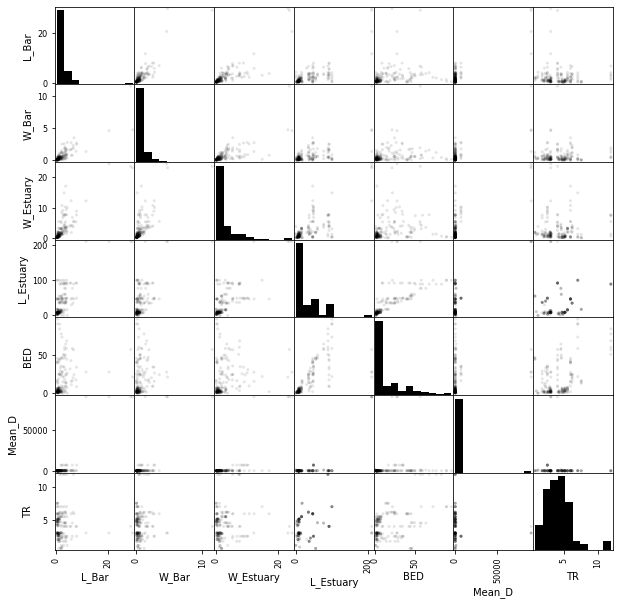

In [71]:
pd_plot.scatter_matrix(df, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['black']})
plt.show()
#line of code taken from The following codes blocks are from Professor Michael Pyrcz (@GeostatsGuy), 
# SubsurfaceDataAnalytics_Naïve_Bayes.ipynb from GeostatsGuy GitHub (https://github.com/GeostatsGuy/Machine_Learning/tree/master/Workflows)

The data looks right, without negative values. Most of the plots are positive skew, showing some high values which could be wrongly interpreted as outliers. These values are related to the scale issues associated to a wide range of rivers of different sizes that Leuven et al. (2016) included in their paper.
As we visually examine the data, it is not possible to identify any obvious multicollinearity between the features. 

### Workflow

My workflow will be:

1. Ranking feature analysis:

Carry on a feature ranking of the dataset.

2. Inferential Machine Learning: MDS

Pick 3 or 4 features and run a Multidimensional scaling to check if the features help me to delineate a better model by showing me the dissimilarities within the data.

3. Inferential Machine Learning: PCA

If the increase in features allow me to better understand the dataset, I will use Principal Components Analysis to create a 2D model to try to improve the interpretation of Leuven et al. (2016).

4. Predictor base Method: Naïve Bayes

Check the components calculated in step 3 vs a 2D model using a predictor-base model. I will use Naïve Bayes.


### 1. Ranking Features: 

In this step I will learn about the relationship between the Width and Length of the tidal bars and the predictor features.
This step will have two stages. First, I will calculate Covariance, Correlation Coefficient, Rank Coefficient and Partial Correlation and summarize them in two plots. Then, I will calculate mutual information.

The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Feature_ranking.ipynb from GeostatsGuy GitHub 

https://github.com/GeostatsGuy/Machine_Learning/tree/master/Workflows

#### Stage one: Covariance, Correlation Coefficient, Rank Coefficient and Partial Correlation

**Covariance:** We only care about the results between the two response features and the predictor features. Therefore, we use the .iloc function to cut output to only have the results from the two response features. We repeate this procedure for the other coefficients

In [72]:
covariance_L = df.iloc[:,1:9].cov().iloc[2:,0:1]
covariance_W = df.iloc[:,1:9].cov().iloc[2:,1:2]

**Correlation Coefficient:** 

In [73]:
correlation_L = df.iloc[:,1:9].corr().iloc[2:,0:1]
correlation_W = df.iloc[:,1:9].corr().iloc[2:,1:2]

**Rank Correlation Coefficient:** 

In [74]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,1:9]) 
rank_correlation_L= rank_correlation[2:,0:1]
rank_correlation_W= rank_correlation[2:,1:2]
rank_correlation_pval_L= rank_correlation_pval[2:,0:1]
rank_correlation_pval_W= rank_correlation_pval[2:,1:2]

**Partial Correlation:** 

In [75]:
partial_correlation = partial_corr(df.iloc[:,1:9]) 
partial_correlation_L = partial_correlation[2:,0:1]
partial_correlation_W = partial_correlation[2:,1:2]

**Summaries:** In these two plots we are visualizing the coefficients that we calculated in the last step.

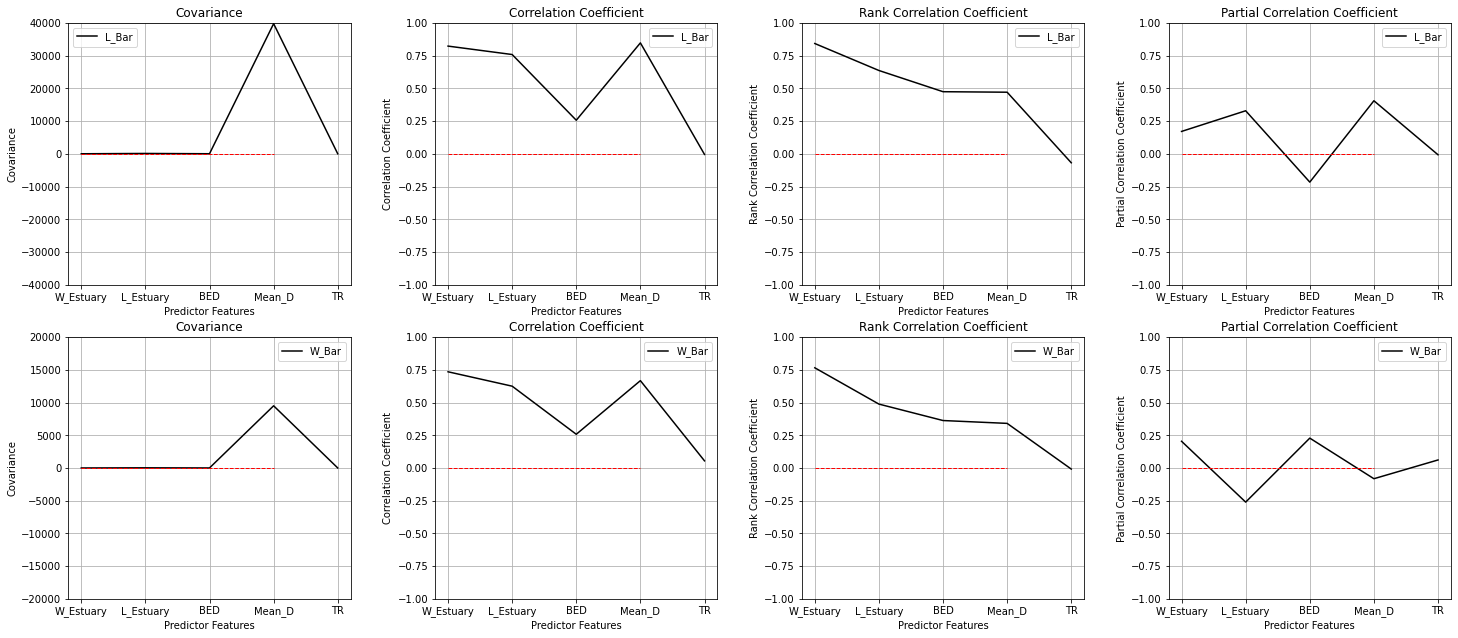

In [76]:
features = df.columns.values[3:]
plt.subplot(241)
plt.plot(features,covariance_L,color='black',label="L_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-40000,40000)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(242)
plt.plot(features,correlation_L,color='black',label="L_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(243)
plt.plot(features,rank_correlation_L,color='black',label="L_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(244)
plt.plot(features,partial_correlation_L,color='black',label="L_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(245)
plt.plot(features,covariance_W,color='black',label="W_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-20000,20000)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(246)
plt.plot(features,correlation_W,color='black',label="W_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(247)
plt.plot(features,rank_correlation_W,color='black',label="W_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplot(248)
plt.plot(features,partial_correlation_W,color='black',label="W_Bar")
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)
plt.legend(loc='best');

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2, wspace=0.3, hspace=0.2)
plt.show()

* Covariance: In both cases the Mean and Max Discharge are out of scale. This is because I am using a wide range of rivers, from a small creek to the Ganges-Brahmaputra.

* Correlation Coefficient: With the correlation coefficient I have a better control of the wide range of the discharge, managing to have all the values in the same scale. The width and length of the estuary and the discharge have strong relations in both plots.

* Rank Correlation: Thanks to the relaxing of the linear assumption we can emphasize the importance of the width and length of the estuary and the discharge in both plots. 

* Partial Correlation: The partial correlation remarkably changes the relation decreasing the importance of the discharge in the width of the bars. The shape of the estuary (Length and width) are still important features for both plots.



**Stage 2:** Calculate mutual information coefficient for the predictor and response features.

In [77]:
x = df.iloc[:,[3,4,5,6,7]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[1]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

In [78]:
x1 = df.iloc[:,[3,4,5,6,7]]             # separate DataFrames for predictor and response features
y1 = df.iloc[:,[2]]

mi1 = mutual_info_regression(x1,np.ravel(y1)) # calculate mutual information
mi1 /= np.max(mi1)                          # calculate relative mutual information

indices1 = np.argsort(mi1)[::-1]            # find indicies for descending order

In [79]:
print("Bar Lenght feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. Feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

Bar Lenght feature ranking:
1. Feature W_Estuary = 1.000000
2. Feature L_Estuary = 0.557144
3. Feature TR = 0.359216
4. Feature BED = 0.289632
5. Feature Mean_D = 0.236867


In [80]:
print("Bar Width feature ranking:")                 # write out the feature importances
for j in range(x.shape[1]):
    print("%d. Feature %s = %f" % (j + 1, x1.columns[indices1][j], mi1[indices1[j]]))

Bar Width feature ranking:
1. Feature W_Estuary = 1.000000
2. Feature L_Estuary = 0.485680
3. Feature TR = 0.256801
4. Feature Mean_D = 0.169589
5. Feature BED = 0.118185


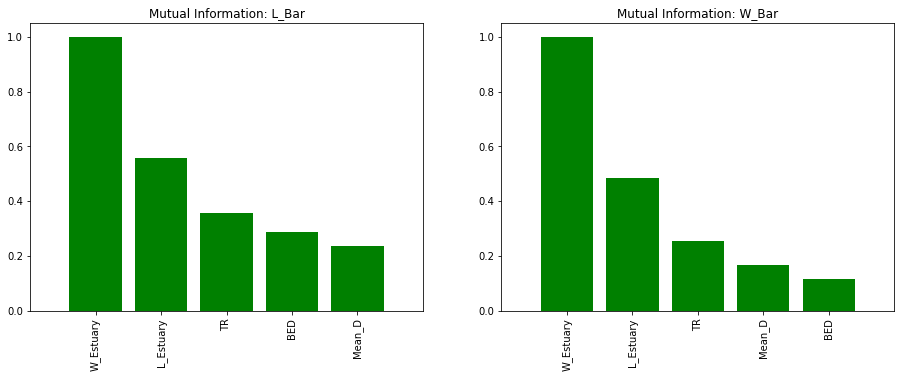

In [81]:
plt.subplot(121)                          # plot the relative mutual information 
plt.title("Mutual Information: L_Bar")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])

plt.subplot(122)                          # plot the relative mutual information 
plt.title("Mutual Information: W_Bar")
plt.bar(range(x1.shape[1]), mi1[indices1],
       color="g", align="center")
plt.xticks(range(x1.shape[1]), x1.columns[indices1],rotation=90)
plt.xlim([-1, x1.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.2)
plt.show()

Mutual Information: The mutual information pointed out that the shape of the estuary  (width and Length) is the most important feature to predict the shape of the bars. Surprisingly,  Tidal Range, a feature which was mostly ignored by the other coefficients of the ranking, is the third in the ranking. Personally, if I had to pick a third feature to build a model, I believe that Discharge has a more important role that the tidal range, an interpretation which is supported by the Correlation Coefficient, Rank Correlation and Partial Correlation. Because I am not 100% sure, in the next step I will include 4 features: W_Estuary, L_Estuary, Mean_D and TR. 


### 2. Inferential Modeling: MDS

In this step I will test the ability of multiple combinations of features to spatially separate the categories of a response feature. These categories will be assigned from the values of our response features. 

To calculate this step, I will use a multidimensional scaling method(MDS) to represent the degree of dissimilarity for the combinations of features. MDS shows the relationship of multiple features in a 2D plot, calculating two new features (MD1 and MD2), which represent the degree of dissimilarity between the data.
These combinations will be:

* W_Estuary, L_Estuary, D_mean and TR (m=4)
* W_Estuary, L_Estuary and TR (m=3)
* W_Estuary and L_Estuary 


The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Multidimensional_Scaling.ipynb from GeostatsGuy GitHub 

https://github.com/GeostatsGuy/Machine_Learning/tree/master/Workflows

**Feature stadarization:** To use MDS we need first to standarize our features. In this step we will use: 

* Width of the Estuary/Delta (W_Estuary) – Km-
* Length of the Estuary/Delta (L_Estuary) – Km-
* Tidal Range of the Estuary/Delta (TR) – m-
* Mean discharge of the River (Mean_D) – m3/s-


In [82]:
features = ['L_Estuary','W_Estuary','TR',"Mean_D"]
x = df.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
xs = StandardScaler().fit_transform(x)

ns_features = []
for i in range(0,len(features)):
    df['NS_'+features[i]] = xs[:,i]
    ns_features.append('NS_'+features[i]) 

df.head()

,Name,L_Bar,W_Bar,W_Estuary,L_Estuary,BED,Mean_D,TR,NS_L_Estuary,NS_W_Estuary,NS_TR,NS_Mean_D
0,Netarts Bay,0.40,0.18,0.49,6.00,0.970,0.412037,2.00,-0.678729,-0.552905,-1.009818,-0.173108
1,Netarts Bay,1.04,0.56,0.88,6.00,3.130,0.412037,2.00,-0.678729,-0.453518,-1.009818,-0.173108
2,Netarts Bay,0.80,0.11,0.95,6.00,2.000,0.412037,2.00,-0.678729,-0.435679,-1.009818,-0.173108
3,Netarts Bay,1.21,0.96,1.06,6.00,1.905,0.412037,2.00,-0.678729,-0.407647,-1.009818,-0.173108
4,Gannel estuary,0.28,0.08,0.12,1.89,0.610,0.711328,4.48,-0.784605,-0.647196,0.151527,-0.173085


For this step and the rest of the workflow, I will use categorical features instead of the originally continue response features to simplify the visualization and evaluation of our model.

I will use 2 elements per categorical feature, taking the median as a separation between the 2 elements. 

In [83]:
bins = [0,0.65,50]            
labels = [0,1]       # assign the labels
category = pd.cut(df['W_Bar'],bins,labels=labels)    
df['W_Barc'] = category    

bins = [0,2.17,50]            
labels = [0,1]       # assign the labels
category1 = pd.cut(df['L_Bar'],bins,labels=labels)     # make the 1D array with the labels for our data
df['L_Barc'] = category1   

**Multidimensional Scaling:** Let's run the method on our subset of features ( 𝑚=4,𝑚=3) and project to 2 features ( 𝑝=2 ).

In [84]:
np.random.seed(1867)                               # set the random number seed, so we all get the same answer
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2)                    # instantiate and set the hyperparameter
MDS_transformed4 = embedding.fit_transform(df[ns_features])
MDS_transformed4.shape
del ns_features [3]
MDS_transformed3 = embedding.fit_transform(df[ns_features])
MDS_transformed3.shape

(190, 2)

We have projected our combinations into 2 features (MDS1 and MDS2) to minimize the error in pairwise distance between the samples. Let's add them to the DataFrame.

In [85]:
df['MDS1(4)'] = MDS_transformed4[:,0]
df['MDS2(4)'] = MDS_transformed4[:,1]
df['MDS1(3)'] = MDS_transformed3[:,0]
df['MDS2(3)'] = MDS_transformed3[:,1]

Now, we will plot the components with our response features as the Z variable.

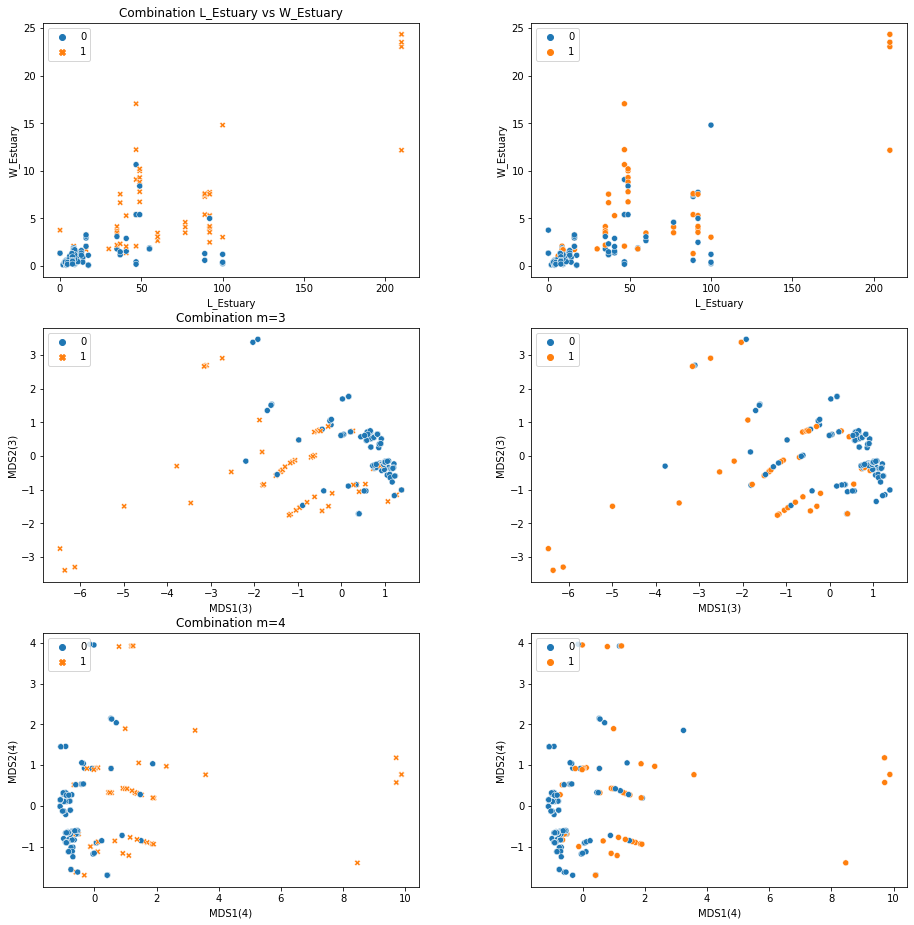

In [86]:
plt.subplot(321)
plt.title("Combination L_Estuary vs W_Estuary")
pairplot = sns.scatterplot(x = df['L_Estuary'],y = df['W_Estuary'],hue = df['L_Barc'],style=df['L_Barc'])
plt.legend(loc='upper left');

plt.subplot(322)
pairplot = sns.scatterplot(x = df['L_Estuary'],y = df['W_Estuary'],hue = df['W_Barc'])
plt.legend(loc='upper left');

plt.subplot(323)
plt.title("Combination m=3")
pairplot = sns.scatterplot(x = df['MDS1(3)'],y = df['MDS2(3)'],hue = df['L_Barc'],style=df['L_Barc'])
plt.legend(loc='upper left');

plt.subplot(324)
pairplot = sns.scatterplot(x = df['MDS1(3)'],y = df['MDS2(3)'],hue = df['W_Barc'])
plt.legend(loc='upper left');

plt.subplot(325)
plt.title("Combination m=4")
pairplot = sns.scatterplot(x = df['MDS1(4)'],y = df['MDS2(4)'],hue = df['L_Barc'],style=df['L_Barc'])
plt.legend(loc='upper left');

plt.subplot(326)
pairplot = sns.scatterplot(x = df['MDS1(4)'],y = df['MDS2(4)'],hue = df['W_Barc'])
plt.legend(loc='upper left');

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=3, wspace=0.3, hspace=0.2)
plt.show()

From the plots, the combination with 3 features (m=3) is the one which separates the categories in the clearest way. Therefore, I will use the features of this combination (L_Estuary,W_Estuary and TR) and use principal components to reduce the dimension of my model maintaining the gain in information.

From MDS we learn that the 3-feature combination is probably the most efficient to separate the categories in the predictor space.

### 3. Inferencial Modeling: PCA 

In this step I will use Principal Component Analysis(PCA) to create a 2D model incorporating the 3 features that I selected on the MDS step.

PCA allows to lower the dimensions of our predictor features by transforming our set of observations into a set of linearly uncorrelated features (the principal components), which preserve most of the variance explained from our original features.

The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub
https://github.com/GeostatsGuy/Machine_Learning/tree/master/Workflows

First, I will reset my dataset and run again the standarization of the features that I will use in this step.

In [87]:
os.chdir("D:/Fall2020") 
df1 = pd.read_csv('bars.csv', delimiter=";") 
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
L_Bar,190.0,2.178732,3.616128,0.06,0.572500,1.140000,2.582500,29.79
W_Bar,190.0,0.656337,1.097325,0.02,0.140000,0.325000,0.657500,11.49
LBI,190.0,2.310526,0.862747,0.00,2.000000,2.000000,3.000000,5.00
W_Estuary,190.0,2.659621,3.934404,0.07,0.490000,1.260000,3.115000,24.33
BED,190.0,15.884366,20.857400,0.00,1.873750,5.375000,24.378750,96.17
L_Estuary,190.0,32.347684,38.921699,0.00,8.400000,13.130000,46.760000,210.00
Mean_D,190.0,2240.988957,12977.445233,0.00,1.892083,16.229417,85.645833,90000.00
TR,190.0,4.156421,2.141097,0.65,2.610000,4.000000,5.140000,11.90


In [88]:
features = ['L_Estuary','W_Estuary','TR']
x = df1.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
xs = StandardScaler().fit_transform(x)
ns_features = []
for i in range(0,len(features)):
    df1['NS_'+features[i]] = xs[:,i]
    ns_features.append('NS_'+features[i])
    
bins = [0,0.65,50]            
labels = [0,1]       # assign the labels
category = pd.cut(df1['W_Bar'],bins,labels=labels)    
df1['W_Barc'] = category    

bins = [0,2.17,50]            
labels = [0,1]       # assign the labels
category1 = pd.cut(df1['L_Bar'],bins,labels=labels)     # make the 1D array with the labels for our data
df1['L_Barc'] = category1   


Secondly, I will run the PCA method for 2 components.

In [89]:
embedding2 = PCA(n_components=2)
pca=embedding2.fit(df1[ns_features])
pca1 = embedding2.fit_transform(df1[ns_features])
df1[["PCA1","PCA2"]] = pd.DataFrame(pca1, columns=['PCA1','PCA2'])  

Let´s check the variance explained by these two components.

In [90]:
print('Variance explained by PC1 and PC2 =', (np.round(pca.explained_variance_ratio_,3)))
print('First Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[0],3)) + ' of the total variance.')
print('Second Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[1],3)) + ' of the total variance.')
a=float(np.round(pca.explained_variance_ratio_[1],3))
b=float(np.round(pca.explained_variance_ratio_[0],3))
print('Total variance explained: ',(np.round(a+b,3)),' of the total variance.')

Variance explained by PC1 and PC2 = [0.601 0.318]
First Principal Component explains 0.601 of the total variance.
Second Principal Component explains 0.318 of the total variance.
Total variance explained:  0.919  of the total variance.


The variance explain is Good (92%), so we successfully reduced our 3 features to 2 dimension with our calculation.

Now let´s check our PCA results with the response feature as Z. I will also plot the results obtained using MDS for each response feature.

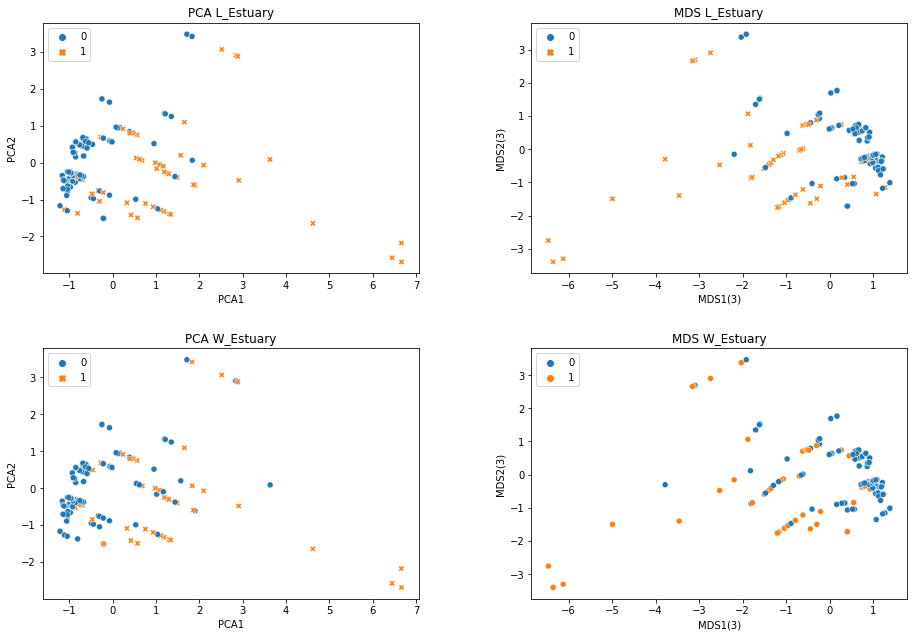

In [93]:
plt.subplot(221)
plt.title("PCA L_Estuary")
pairplot = sns.scatterplot(x = df1['PCA1'],y = df1['PCA2'],hue = df1['L_Barc'],style=df1['L_Barc'])
plt.legend(loc='upper left');
plt.subplot(222)
plt.title("MDS L_Estuary")
pairplot = sns.scatterplot(x = df['MDS1(3)'],y = df['MDS2(3)'],hue = df['L_Barc'],style=df['L_Barc'])
plt.legend(loc='upper left');
plt.subplot(223)
plt.title("PCA W_Estuary")
pairplot = sns.scatterplot(x = df1['PCA1'],y = df1['PCA2'],hue = df1['W_Barc'],style=df1['W_Barc'])
plt.legend(loc='upper left');
plt.subplot(224)
pairplot = sns.scatterplot(x = df['MDS1(3)'],y = df['MDS2(3)'],hue = df['W_Barc'])
plt.title("MDS W_Estuary")
plt.legend(loc='upper left');
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2, wspace=0.3, hspace=0.3)
plt.show()

The plots show that the results obtained using PCA are similar to the ones calculated with MDS. 

The Principal component analysis allowed us to reduce the dimensions of our model losing only 8% of variance explained.

In the Next step I will test this PC model against a 2 feature model using the two best ranked predictor features to test which of the two performed better.


### 3. Test Principal Components: 

For testing my PC I will use Naïve Bayes method. I will again use the categorical features calculated in step 2 as response features.
Naive Bayes assumes that each input variable is independent. This is a strong assumption and unrealistic for real data; however, the method could be helpful in complex problems.

The following functions will be used in the workflow. The following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_Naïve_Bayes.ipynb from GeostatsGuy GitHub

https://github.com/GeostatsGuy/Machine_Learning/tree/master/Workflows

First, we divide our data in two groups: Training and Testing. The proportion will be 75% training, 25% testing. I will define four groups, two to evaluate the principal component result with the categorical features, and two which will evaluate the use of the 2 features model.

In [121]:
X_trainL, X_testL, y_trainL, y_testL = train_test_split(df1[["PCA1","PCA2"]], df1["L_Barc"], test_size=0.25, random_state=29586)
X_trainW, X_testW, y_trainW, y_testW = train_test_split(df1[["PCA1","PCA2"]], df1["W_Barc"], test_size=0.25, random_state=29586)
X_trainP1, X_testP1, y_trainP1, y_testP1 = train_test_split(df1[["NS_W_Estuary","NS_L_Estuary"]], df1["L_Barc"], test_size=0.25, random_state=29586)
X_trainP2, X_testP2, y_trainP2, y_testP2 = train_test_split(df1[["NS_W_Estuary","NS_L_Estuary"]], df1["W_Barc"], test_size=0.25, random_state=29586)

I will use a naïve prior (50%-50%), which assumes that I don´t know anything about my dataset beforehand. Let´s calculate the method:

In [122]:
priors = (0.5,0.5)  
gnbL = GaussianNB(priors = priors)
gnbW = GaussianNB(priors = priors)
gnbP = GaussianNB(priors = priors)
GaussianNB_fitL = gnbL.fit(X_trainL,y_trainL) 
GaussianNB_fitW = gnbW.fit(X_trainW,y_trainW)
GaussianNB_fitP1 = gnbW.fit(X_trainP1,y_trainP1)
GaussianNB_fitP2 = gnbW.fit(X_trainP2,y_trainP2)
y_predL = GaussianNB_fitL.predict(np.c_[X_testL['PCA1'],X_testL['PCA2']]) # predict over the testing data
y_predW = GaussianNB_fitW.predict(np.c_[X_testW['PCA1'],X_testW['PCA2']]) # predict over the testing data
y_predP1 = GaussianNB_fitP1.predict(np.c_[X_testP1['NS_W_Estuary'],X_testP1['NS_L_Estuary']]) # predict over the testing data
y_predP2 = GaussianNB_fitP2.predict(np.c_[X_testP2['NS_W_Estuary'],X_testP2['NS_L_Estuary']]) # predict over the testing data

**Clssification reports**: where we evaluate the accuracy of our models. 
* Precision: The ratio of the true positives divided by all pasitives (true positives + false positives)
* Recall: The ratio of true positives divided by all cases of the category
* Fi-score: The harmonic mean of recall and precision.
* Support: The number of samples of each category in the testing data.    

In [123]:
print("PCA vs L_Barc \n ",classification_report(y_testL, y_predL, labels=[0,1]))
print("2F ranking vs L_Barc \n ",classification_report(y_testP1, y_predP1, labels=[0,1]))
print("PCA vs W_Barc \n ",classification_report(y_testW, y_predW, labels=[0,1]))
print("2F  vs W_Barc \n ",classification_report(y_testP2, y_predP2, labels=[0,1]))

PCA vs L_Barc 
                precision    recall  f1-score   support

           0       0.84      0.94      0.89        33
           1       0.82      0.60      0.69        15

    accuracy                           0.83        48
   macro avg       0.83      0.77      0.79        48
weighted avg       0.83      0.83      0.83        48

2F ranking vs L_Barc 
                precision    recall  f1-score   support

           0       0.84      0.94      0.89        33
           1       0.82      0.60      0.69        15

    accuracy                           0.83        48
   macro avg       0.83      0.77      0.79        48
weighted avg       0.83      0.83      0.83        48

PCA vs W_Barc 
                precision    recall  f1-score   support

           0       0.88      0.74      0.80        38
           1       0.38      0.60      0.46        10

    accuracy                           0.71        48
   macro avg       0.62      0.67      0.63        48
weighted avg    

The classification reports show that the PC model and the 2 Features model have similar results for L_Bar (tied in 83% for all the coefficients), but for W_Bar, the 2 Features model has sightly better results in the three coefficients ( Precision= 0.77% vs 0.78, Recall= 0.71 vs 0.77 and F-scores=0.73% vs 0.77%). Additionally, The L_bar model seems to be more accurate globally than the W_bar model.

**Confusion Matrix:** 
* Left to right diagonal: true positives.
* right to left diagonal: wrong predictions.

In [124]:
print("PCA vs L_Barc")
print(confusion_matrix(y_testL, y_predL))
print("2 features ranking vs L_Barc")
print(confusion_matrix(y_testP1, y_predP1))
print("PCA vs W_Barc")
print(confusion_matrix(y_testW, y_predW))
print("2 features ranking vs L_Barc")
print(confusion_matrix(y_testP2, y_predP2))

PCA vs L_Barc
[[31  2]
 [ 6  9]]
2 features ranking vs L_Barc
[[31  2]
 [ 6  9]]
PCA vs W_Barc
[[28 10]
 [ 4  6]]
2 features ranking vs L_Barc
[[32  6]
 [ 5  5]]


The results of the Confunsion matrix show again the tie between the two models on L_Bar (they tied in 8 missmatchings each) and the slightly better performance of the 2 feature model vs the PC model (14 vs 11 mismatchings) for W_bar. 

**Model Visualization:** 
    
Now, we will visualize the models over the entire feature space: the plots with training data on the right and the testing data on the left.

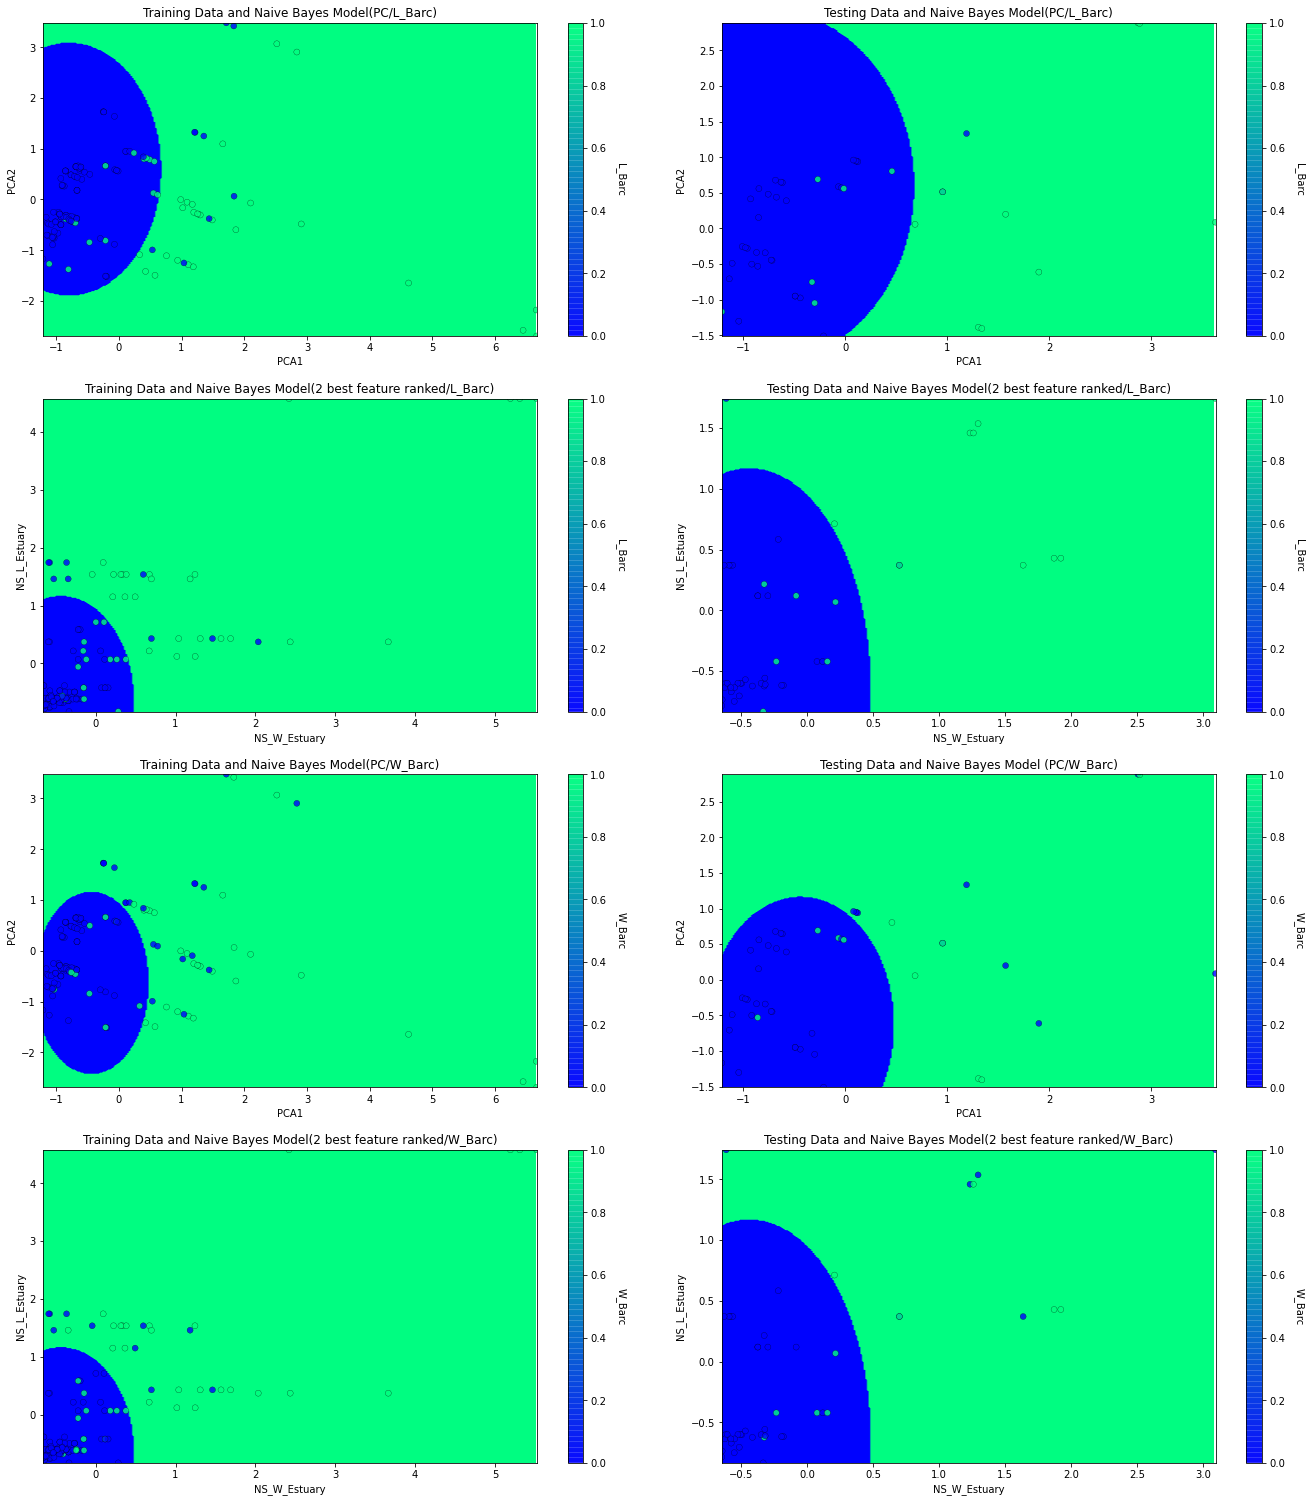

In [139]:
plt.subplot(421)
visualize_model(GaussianNB_fitL,X_trainL["PCA1"],min(X_trainL["PCA1"]),max(X_trainL["PCA1"])
                ,X_trainL["PCA2"],min(X_trainL["PCA2"]),max(X_trainL["PCA2"]),y_trainL,min(y_trainL)
                ,max(y_trainL),'Training Data and Naive Bayes Model(PC/L_Barc)')
plt.subplot(422)
visualize_model(GaussianNB_fitL,X_testL["PCA1"],min(X_testL["PCA1"]),max(X_testL["PCA1"])
                ,X_testL["PCA2"],min(X_testL["PCA2"]),max(X_testL["PCA2"]),y_testL,min(y_testL)
                ,max(y_testL),'Testing Data and Naive Bayes Model(PC/L_Barc)')

plt.subplot(423)
visualize_model(GaussianNB_fitP1,X_trainP1["NS_W_Estuary"],min(X_trainP1["NS_W_Estuary"]),max(X_trainP1["NS_W_Estuary"])
                ,X_trainP1["NS_L_Estuary"],min(X_trainP1["NS_L_Estuary"]),max(X_trainP1["NS_L_Estuary"]),y_trainP1,min(y_trainP1)
                ,max(y_trainP1),'Training Data and Naive Bayes Model(2 best feature ranked/L_Barc)')
plt.subplot(424)
visualize_model(GaussianNB_fitP1,X_testP1["NS_W_Estuary"],min(X_testP1["NS_W_Estuary"]),max(X_testP1["NS_W_Estuary"])
                ,X_testP1["NS_L_Estuary"],min(X_testP1["NS_L_Estuary"]),max(X_testP1["NS_L_Estuary"]),y_testP1,min(y_testP1)
                ,max(y_testP1),'Testing Data and Naive Bayes Model(2 best feature ranked/L_Barc)')
plt.subplot(425)
visualize_model(GaussianNB_fitW,X_trainW["PCA1"],min(X_trainW["PCA1"]),max(X_trainW["PCA1"])
                ,X_trainW["PCA2"],min(X_trainW["PCA2"]),max(X_trainW["PCA2"]),y_trainW,min(y_trainW)
                ,max(y_trainW),'Training Data and Naive Bayes Model(PC/W_Barc)')
plt.subplot(426)
visualize_model(GaussianNB_fitW,X_testW["PCA1"],min(X_testW["PCA1"]),max(X_testW["PCA1"])
                ,X_testW["PCA2"],min(X_testW["PCA2"]),max(X_testW["PCA2"]),y_testW,min(y_testW)
                ,max(y_testW),'Testing Data and Naive Bayes Model (PC/W_Barc)')
plt.subplot(427)
visualize_model(GaussianNB_fitP2,X_trainP2["NS_W_Estuary"],min(X_trainP2["NS_W_Estuary"]),max(X_trainP2["NS_W_Estuary"])
                ,X_trainP2["NS_L_Estuary"],min(X_trainP2["NS_L_Estuary"]),max(X_trainP2["NS_L_Estuary"]),y_trainP2,min(y_trainP2)
                ,max(y_trainP2),'Training Data and Naive Bayes Model(2 best feature ranked/W_Barc)')
plt.subplot(428)
visualize_model(GaussianNB_fitP2,X_testP2["NS_W_Estuary"],min(X_testP2["NS_W_Estuary"]),max(X_testP2["NS_W_Estuary"])
                ,X_testP2["NS_L_Estuary"],min(X_testP2["NS_L_Estuary"]),max(X_testP2["NS_L_Estuary"]),y_testP2,min(y_testP2)
                ,max(y_testP2),'Testing Data and Naive Bayes Model(2 best feature ranked/W_Barc)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=5, wspace=0.1, hspace=0.2)
plt.show()

The visualization shows the same trends pointed out by the classification report and the confusion matrix, with a comparable performance in both models for the L_bar, a slight improve in the 2 Features model vs the PC model, and a globally better performance of the L_bar models vs the W_bar models.

From the Naïve Bayes method we learned that the PC model didn´t improve the result obtained using the 2 best-ranked features, in fact it worsen it in the case W_bar.


### Conclusions:
* We run a feature ranking to choose which of the features were the best suited to predict the response features.
* We selected 4 features, following geological and statistical criteria, to visualize the dissimilarities within the data using a multivariable scaling method (MDS). We created categorical features from the response feature to simplify the interpretation of the visualization. In the visualization, we recognized that the MDS with the combination of 3 features seemed to work slightly better than the other combinations in separating the categories, therefore we decided to integrate the three features into a 2D model using principal components (PCA).
* We calculated PCA reducing the dimension to 2, only losing 8% of the variance explained.
* We tested the PC obtained against a model using the normalized 2 best-ranked features obtained from the ranking method. To perform this test, we used Naïve Bayes method, assuming a naïve prior. The test indicates that the principal components didn´t improve the result obtained using the two best-ranked features, in fact it worsened it in the case of the width of the bars.

## Next steps:
* Continue exploring the relations between the two best-ranked features (length and width of the Estuary) and the response features, trying to improve the results from Leuven et al. (2016). I will test other non-parametric approaches (random forest, boosting and support vector machines).
* Add more measurements to my dataset because I believe that 190 datapoints are probably not enough to have a representative sample.




This workflow is free to be shown.


I hope this was helpful,

*Fernando*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
